# AI for Vision-Language Models in Medical Imaging Coding Part

In [2]:
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import re
import json
import os
import csv
import ast
import random


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "llava-hf/llava-1.5-7b-hf"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForVision2Seq.from_pretrained(model_id, device_map="auto")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [13]:
def get_prediction(image, prompt, task):
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=96)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    if task == "classify":
        return generated_text.split("ASSISTANT:")[-1].lower().strip()
    
    elif task == "bbox":
        return ast.literal_eval(generated_text.split("ASSISTANT:")[-1].strip())
    
    elif task == "describe":
        return generated_text.split("ASSISTANT:")[-1].strip()

## Chest X-Ray Images

### 1. Classification Task

#### 1.1 Get classification predicitions:

In [ ]:
image_folder = "chest_xrays/images"
image_paths = os.listdir(image_folder)

with open("chest_xrays/annotations_len_50.json", "r") as file:
    annotations = json.load(file)

results = []

for image_path in tqdm(image_paths):
    image_name = image_path.split(".")[0]
    image = Image.open(os.path.join(image_folder, image_path)).convert("RGB")
    label = annotations[image_name]["status"]
    prompt = "USER: <image>\nClassify this chest X-ray image as 'healthy' or 'unhealthy'. Respond only with the label. ASSISTANT:"

    prediction = get_prediction(image=image, prompt=prompt, task="classify")
    results.append({"image": image_name, "prediction": prediction, "label": label})


with open("results/xray_predictions.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["image", "prediction", "label"])
    writer.writeheader()
    writer.writerows(results)



100%|██████████| 50/50 [4:39:53<00:00, 335.87s/it]  


#### 1.2 Compute Accuracy and F1-Score:

In [20]:
df = pd.read_csv("results/xray_predictions.csv")
pred = df["prediction"].tolist()
gt = df["label"].tolist()
acc = accuracy_score(gt, pred)
f1 = f1_score(gt, pred, pos_label="unhealthy")

print(f"Accuracy: {100*acc}%")
print(f"F1-Score: {f1}")

#Always predicting unhealthy
pred = ["unhealthy" for _ in range(len(gt))]
acc_baseline = accuracy_score(gt, pred)
f1_baseline = f1_score(gt, pred, pos_label="unhealthy")
print(acc_baseline, f1_baseline)

Accuracy: 64.0%
F1-Score: 0.18181818181818182
0.24 0.3870967741935484


### 2. Abnormality Grounding

#### 2.1 Predict the bounding boxes:

In [ ]:
image_folder = "chest_xrays/images"
image_paths = os.listdir(image_folder)

with open("chest_xrays/annotations_len_50.json", "r") as file:
    annotations = json.load(file)

bbox_image_paths = []

for path in image_paths:
    if len(annotations[path.split(".")[0]]["bbox_2d"]) != 0:
        bbox_image_paths.append(path)

results = {}
counter = 1
total = len(bbox_image_paths)

for path in bbox_image_paths:
    image_name = path.split(".")[0]
    image = Image.open(os.path.join(image_folder, path)).convert("RGB")
    results[image_name] = []
    print(f"Calculating bounding boxes for image {counter}/{total}:")
    for entry in tqdm(annotations[image_name]["bbox_2d"], desc="Locating diseases in current image"):
        disease = entry[-1]
        bbox = entry[:4]
        prompt = f"USER: <image>\nPlease locate {disease} and output the bounding boxes in the format [x1, y1, x2, y2]. ASSISTANT:"
        prediction = get_prediction(image=image, prompt=prompt, task="bbox")
        prediction.append(disease)
        results[image_name].append(prediction)
    counter +=1

with open("results/xray_bbox.json", "w") as f:
    json.dump(results, f, indent=4)

Calculating bounding boxes for image 1/12:


Locating diseases in current image:   0%|          | 0/6 [00:00<?, ?it/s]

Locating diseases in current image: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Calculating bounding boxes for image 2/12:


Locating diseases in current image: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Calculating bounding boxes for image 3/12:


Locating diseases in current image: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Calculating bounding boxes for image 4/12:


Locating diseases in current image: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Calculating bounding boxes for image 5/12:


Locating diseases in current image: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


Calculating bounding boxes for image 6/12:


Locating diseases in current image: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Calculating bounding boxes for image 7/12:


Locating diseases in current image: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


Calculating bounding boxes for image 8/12:


Locating diseases in current image: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Calculating bounding boxes for image 9/12:


Locating diseases in current image: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Calculating bounding boxes for image 10/12:


Locating diseases in current image: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


Calculating bounding boxes for image 11/12:


Locating diseases in current image: 100%|██████████| 18/18 [00:32<00:00,  1.80s/it]


Calculating bounding boxes for image 12/12:


Locating diseases in current image: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


#### 2.2 Calculate mAP Score:

In [34]:
from scripts.calculate_map import compute_map_supervision

with open("results/xray_bbox.json", "r") as f:
    pred_dict = json.load(f)
with open("chest_xrays/annotations_len_50.json", "r") as f:
    gt_dict = json.load(f)

pred_boxes = []
pred_classes = []
gt_boxes = []
gt_classes = []

keys = pred_dict.keys()
class_to_id = {}
id_counter = 0

for key in keys:
    for box in pred_dict[key]:
        pred_boxes.append(box[0:4])
        pred_classes.append(box[-1])
    for box in gt_dict[key]["bbox_2d"]:
        gt_boxes.append(box[0:4])
        gt_classes.append(box[-1])

# Scale predicted bounding boxes since model outputs are always between 0 and 1
pred_boxes = (np.array(pred_boxes) * 1024).tolist()

# Turn classes into IDs

for cls in pred_classes:
    if cls not in class_to_id:
        class_to_id[cls] = id_counter
        id_counter += 1

pred_classes = [class_to_id[cls] for cls in pred_classes]
gt_classes = [class_to_id[cls] for cls in gt_classes]

result = compute_map_supervision(pred_boxes, pred_classes, gt_boxes, gt_classes)

mAP@50:95: 5.0630063006300645e-05
mAP@50:    0.0005063006300630064
mAP@75:    0.0


#### 2.3 Bounding box visualization 

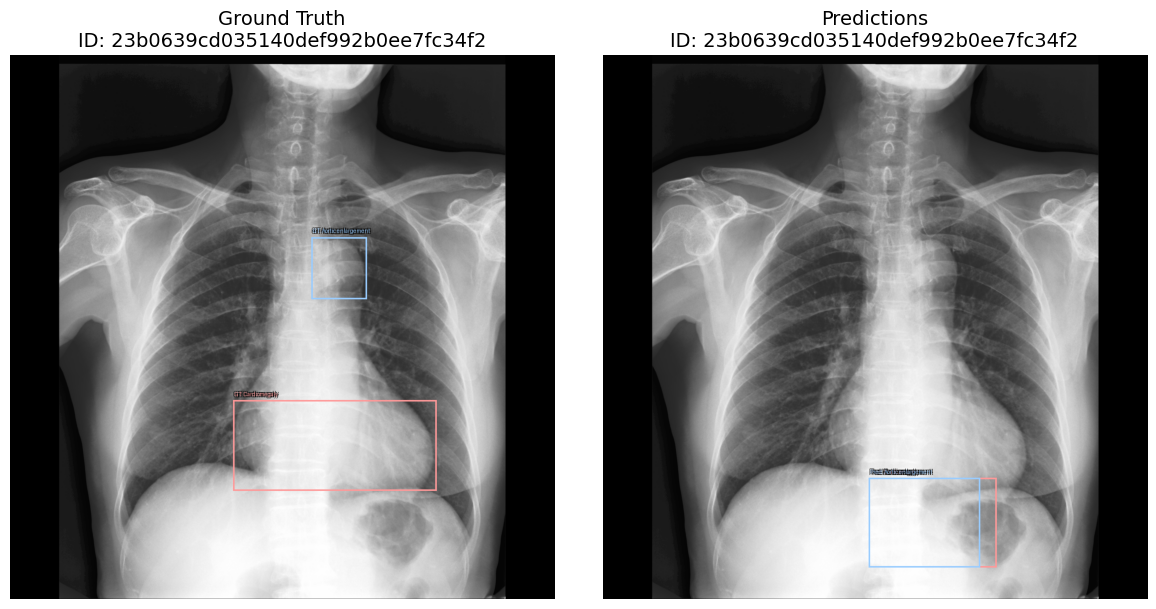

In [12]:
# ====== Configuration ======
FOLDER = './chest_xrays'
ANNOTATIONS_PATH = os.path.join(FOLDER, 'annotations_len_50.json')
PREDICTIONS_PATH = "results/xray_bbox.json"  # Predicted bboxes file
IMAGES_PATH = os.path.join(FOLDER, 'images')
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"  # Fallback to default if not found
FONT_SIZE = 32
FIG_SIZE = (12, 6)
BASE_COLORS = ['#ff9999','#99ccff','#99ff99','#ffcc99','#cc99ff','#99ffff','#ff99ff','#ffff99']

# ====== Helper Functions ======
def draw_text(draw, pos, text, font, color, outline=2):
    for dx in [-outline, outline]:
        for dy in [-outline, outline]:
            draw.text((pos[0]+dx, pos[1]+dy), text, font=font, fill='black')
    draw.text(pos, text, font=font, fill=color)

def get_color(label, color_map):
    if label not in color_map:
        if len(color_map) < len(BASE_COLORS):
            color_map[label] = BASE_COLORS[len(color_map)]
        else:
            r, g, b = np.random.randint(0, 256, size=3)
            color_map[label] = (r, g, b)
    return color_map[label]

def visualize_boxes_only(img_id, boxes, label_prefix, color_map):
    img_file = os.path.join(IMAGES_PATH, img_id + '.png')
    if not os.path.exists(img_file):
        print(f"Image not found: {img_file}")
        return None

    img = Image.open(img_file).convert("RGB")
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype(FONT_PATH, FONT_SIZE)
    except:
        font = ImageFont.load_default()

    for x1, y1, x2, y2, label in boxes:
        color = get_color(label, color_map)  # Use label only!
        for w in range(3):
            draw.rectangle([x1-w, y1-w, x2+w, y2+w], outline=color)
        bbox_text = draw.textbbox((0, 0), label, font=font)
        text_w = bbox_text[2] - bbox_text[0]
        text_h = bbox_text[3] - bbox_text[1]
        text_pos = (x1, y2 + 10) if y1 < 50 else (x1, y1 - text_h - 10)
        draw_text(draw, text_pos, f"{label_prefix}: {label}", font, color)

    return img

# ====== Main Execution ======
with open(ANNOTATIONS_PATH) as f:
    annotations = json.load(f)

with open(PREDICTIONS_PATH) as f:
    predictions = json.load(f)

# Select one random unhealthy image
unhealthy_keys = [k for k, v in annotations.items() if v['status'] == 'unhealthy']
sample_key = random.choice(unhealthy_keys)

# Extract boxes
ann = annotations[sample_key]
gt_boxes = ann.get('bbox_2d', [])
pred_boxes = predictions.get(sample_key, [])

scaled_pred_boxes = []
for box in pred_boxes:
    if len(box) == 5:
        x1, y1, x2, y2, label = box
        scaled_box = [x1 * 1024, y1 * 1024, x2 * 1024, y2 * 1024, label]
        scaled_pred_boxes.append(scaled_box)
    else:
        print(f"Warning: Unexpected box format: {box}")
        
pred_boxes = scaled_pred_boxes
# Prepare color map
color_map = {}

# Generate images
gt_img = visualize_boxes_only(sample_key, gt_boxes, 'GT', color_map)
pred_img = visualize_boxes_only(sample_key, pred_boxes, 'Pred', color_map)

# Display side-by-side
if gt_img and pred_img:
    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    axes[0].imshow(gt_img)
    axes[0].set_title(f"Ground Truth\nID: {sample_key}", fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(pred_img)
    axes[1].set_title(f"Predictions\nID: {sample_key}", fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Error: Could not load one or both images.")

## Brain MRI Images

### 1. Description Generation

In [ ]:
image_folder = "nova_brain/images"
image_paths = os.listdir(image_folder)

results = {}

for image_path in tqdm(image_paths):
    case = image_path.split("_")[0]
    image = Image.open(os.path.join(image_folder, image_path)).convert("RGB")
    prompt = "USER: <image>\nPlease describe the given medical image. Leave out newline characters. ASSISTANT:"
    prediction = get_prediction(image=image, prompt=prompt, task="describe")
    
    if case not in results:
        results[case] = {}
    results[case][image_path] = prediction

with open("results/mri_descriptions.json", "w") as f:
    json.dump(results, f, indent=4)

100%|██████████| 92/92 [07:21<00:00,  4.79s/it]


In [11]:
import nltk
nltk.download('punkt_tab')
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

with open("nova_brain/annotations.json", "r") as f:
    ref_dict = json.load(f)

with open("results/mri_descriptions.json", "r") as f:
    cand_dict = json.load(f)


references = []
candidates = []

for case in ref_dict.keys():
    findings_dict = ref_dict[case]["image_findings"]
    for image in findings_dict.keys():
        cap = findings_dict[image]["caption"]
        references.append(cap)


for case in cand_dict.keys():
    findings_dict = cand_dict[case]
    for image in findings_dict.keys():
        cap = findings_dict[image]
        candidates.append(cap)

for i, (ref, cand) in enumerate(zip(references, candidates)):
    ref_tokens = word_tokenize(ref)
    cand_tokens = word_tokenize(cand)
    
    # Calculate BLEU scores with different n-gram weights
    bleu1 = sentence_bleu([ref_tokens], cand_tokens, weights=(1, 0, 0, 0))
    bleu2 = sentence_bleu([ref_tokens], cand_tokens, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu([ref_tokens], cand_tokens, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu([ref_tokens], cand_tokens, weights=(0.25, 0.25, 0.25, 0.25))
    
    print(f"\nSample {i+1}:")
    print(f"Reference: {ref}")
    print(f"Candidate: {cand}")
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")


Sample 1:
Reference: Axial contrast-enhanced T1 3D sequence shows an isointense mass and slight enhancement.
Candidate: The image displays a close-up of a human brain, focusing on the frontal lobe. The brain is shown in a cross-sectional view, revealing the intricate structure of the cerebral cortex. The image provides a detailed look at the various regions and folds of the brain, highlighting its complexity and importance in human cognition and behavior.
BLEU-1: 0.0328
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000

Sample 2:
Reference: Axial T2 gradient image shows a small hypointense area within the intraventricular mass, compatible with calcification.
Candidate: The image displays a close-up view of a human brain, focusing on the frontal lobe. The brain is shown in a cross-sectional view, revealing the intricate structure of the cerebral cortex. The image provides a detailed look at the various regions and folds of the brain, highlighting the complexity of this vital organ.
BLEU-1: 

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/philipproessel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/Users/philipproessel/miniconda3/envs/vlm/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/philipproessel/miniconda3/envs/vlm/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/philipproessel/miniconda3/envs/vlm/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning:

### Task 2: Abnormality Detection

In [ ]:
image_folder = "nova_brain/images"
image_paths = os.listdir(image_folder)

results = {}

for image_path in tqdm(image_paths):
    case = image_path.split("_")[0]
    image = Image.open(os.path.join(image_folder, image_path)).convert("RGB")
    prompt = "USER: <image>\nPlease locate any abnormal areas in the MRI image and output the bounding boxes in the format [x1, y1, x2, y2]. Output only the bounding box and nothing else. ASSISTANT:"
    prediction = get_prediction(image=image, prompt=prompt, task="bbox")
    
    if case not in results:
        results[case] = {}
    results[case][image_path] = prediction

with open("results/mri_abnormalities.json", "w") as f:
    json.dump(results, f, indent=4)

100%|██████████| 92/92 [02:49<00:00,  1.84s/it]


In [12]:
from scripts.calculate_map import compute_map_supervision

with open("results/mri_abnormalities.json", "r") as f:
    pred_dict = json.load(f)
with open("nova_brain/annotations.json", "r") as f:
    gt_dict = json.load(f)

pred_boxes = []
gt_boxes = []

cases = pred_dict.keys()

for case in cases:
    for image in pred_dict[case].keys():

        gt_box_list = gt_dict[case]["image_findings"][image]["bbox_2d_gold"]
        pred_box = pred_dict[case][image]

        for gt_box in gt_box_list:
            gt_boxes.append(gt_box)
            pred_boxes.append(pred_box)

# Scale predicted bounding boxes
pred_boxes = (np.array(pred_boxes) * 1024).tolist()

# Compute mAP
result = compute_map_supervision(pred_boxes, None, gt_boxes, None)

mAP@50:95: 0.002931114090366856
mAP@50:    0.018508116859021716
mAP@75:    0.0


🖼️ case0255_001.png: Sagittal T2 Flair image showing a subcutaneous extracranial soft tissue mass with high signal intensity and internal vascular structures with low signal intensity, probably representing flow voids.
🖼️ case0255_002.png: Non-contrast enhanced sagittal T1-weighted image showing a subcutaneous extracranial soft tissue mass with intermediate signal intensity.
🖼️ case0255_003.png: Contrast-enhanced sagittal T1-weighted image showing high signal intensity. There is contrast enhancement in parts of the lesion, indicating communication with the venous system. A communicating emissary vein can be seen passing from the lesion through the skull.


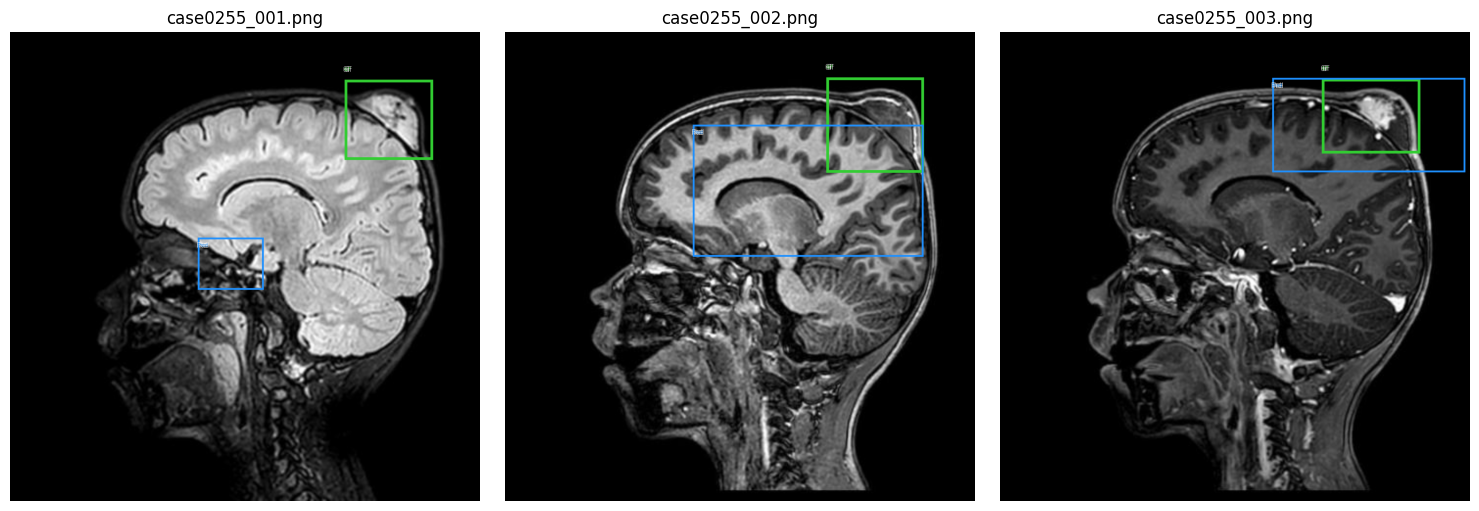

In [42]:
NUM_SAMPLES = 1  # Show one sample
FOLDER = './nova_brain'
ANNOTATIONS_PATH = os.path.join(FOLDER, 'annotations.json')
PREDICTIONS_PATH = "results/mri_abnormalities.json"
IMAGES_PATH = os.path.join(FOLDER, 'images')
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
FONT_SIZE = 32

# Colors
GT_COLOR = 'limegreen'
PRED_COLOR = 'dodgerblue'

def draw_text(draw, pos, text, font, color='black', outline=2):
    for dx in [-outline, outline]:
        for dy in [-outline, outline]:
            draw.text((pos[0]+dx, pos[1]+dy), text, font=font, fill='white')
    draw.text(pos, text, font=font, fill=color)

def visualize_gt_and_pred(case_id, case_data, pred_data):
    images = case_data.get('image_findings', {})
    if not images:
        print(f"No images found for case {case_id}")
        return
    
    try:
        font = ImageFont.truetype(FONT_PATH, FONT_SIZE)
    except:
        font = ImageFont.load_default()

    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(5 * n_images, 5))
    if n_images == 1:
        axes = [axes]

    for i, (img_filename, img_info) in enumerate(images.items()):
        print(f"🖼️ {img_filename}: {img_info.get('caption', '')}")
        
        img_path = os.path.join(IMAGES_PATH, img_filename)
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        # --- Draw Ground Truth Boxes ---
        bboxes = img_info.get('bbox_2d_gold', [])
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            draw.rectangle([x1, y1, x2, y2], outline=GT_COLOR, width=6)
            draw_text(draw, (x1, y1 - 30), "GT", font, color=GT_COLOR)

        # --- Draw Predicted Box (converted from normalized to pixel space) ---
        pred_box = pred_data.get(case_id, {}).get(img_filename)
        if pred_box:
            px1, py1, px2, py2 = [int(coord * 1024) for coord in pred_box]
            draw.rectangle([px1, py1, px2, py2], outline=PRED_COLOR, width=4)
            draw_text(draw, (px1, py1 + 10), "Pred", font, color=PRED_COLOR)

        axes[i].imshow(img)
        axes[i].set_title(img_filename, fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    with open(ANNOTATIONS_PATH) as f:
        annotations = json.load(f)

    with open(PREDICTIONS_PATH) as f:
        predictions = json.load(f)

    # Find common cases between GT and predictions
    common_cases = list(set(annotations.keys()) & set(predictions.keys()))
    if not common_cases:
        raise ValueError("No common cases found between annotations and predictions.")

    # Sample and visualize one case
    sample_case_id = random.choice(common_cases)
    sample_case_data = annotations[sample_case_id]
    visualize_gt_and_pred(sample_case_id, sample_case_data, predictions)